In [ ]:
#

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# 使用0050股價資料集進行LSTM實作
import os
import pandas as pd
import numpy as np
from glob import glob

In [12]:
# folder_path= r'D:\01_Taipei_AI\56_Side_Project\Work-LSTM-Stock\0050_Price'
# df=pd.read_csv(folder_path +'\\STOCK_DAY_0050_201812.csv', encoding='Big5',header=1)
# stock_data = df.drop(columns=['Unnamed: 9'])
# stock_data

In [ ]:
# # 去掉後面的說明欄位，以及NaN 值
# import re
# pattern = r'(說明|符號說明|當日統計|ETF證券|權證證券).*?$'
# stock_data = stock_data.applymap(lambda x: re.sub(pattern, '', x) if isinstance(x, str) else x)
# stock_data.dropna(axis=0, how='any', inplace=True) #axis=0 行，axis=1 列
# stock_data

pandas.core.frame.DataFrame

In [13]:
from glob import glob #讀取資料夾所有檔案
import re
# folder_path= r'D:\01_Taipei_AI\56_Side_Project\Work-LSTM-Stock\0050_Price'
folder_path = '/content/drive/MyDrive/Colab/0050_Price'
files = glob(folder_path + '/STOCK_DAY_0050*.csv')
df = pd.concat([pd.read_csv(file, encoding='big5', header=1) for file in files], ignore_index=True)
# 進行資料清理，去除檔案後面文字、NaN 值
df = df.drop(columns=['Unnamed: 9'])
pattern = r'(說明|符號說明|當日統計|ETF證券|權證證券).*?$'
df = df.applymap(lambda x: re.sub(pattern, '', x) if isinstance(x, str) else x)
df.dropna(axis=0, how='any', inplace=True) #axis=0 行，axis=1 列
df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,99/01/04,"20,083,125","1,132,155,005",56.45,56.65,56.05,56.50,0.05,"1,624"
1,99/01/05,"16,453,854","932,015,376",56.80,56.90,56.15,56.50,0.0,"1,866"
2,99/01/06,"19,012,172","1,087,143,829",56.50,57.75,56.50,57.55,1.05,"2,958"
3,99/01/07,"14,110,575","814,344,344",57.60,58.15,57.30,57.40,-0.15,"1,846"
4,99/01/08,"11,342,752","651,830,965",57.30,57.75,57.05,57.75,0.35,"1,493"
...,...,...,...,...,...,...,...,...,...
4238,113/03/25,"9,052,498","1,426,632,970",157.20,158.00,156.95,157.50,0.3,"10,534"
4239,113/03/26,"7,011,591","1,106,518,323",158.30,159.20,156.40,157.60,0.1,"10,423"
4240,113/03/27,"4,644,158","730,810,486",157.40,157.85,156.90,157.65,0.05,"5,803"
4241,113/03/28,"3,438,375","539,015,594",157.30,157.30,155.90,156.90,-0.75,"7,097"


In [14]:
df.to_csv('0050_years.csv', encoding='utf-8', index=False)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3476 entries, 0 to 4242
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      3476 non-null   object 
 1   成交股數    3476 non-null   object 
 2   成交金額    3476 non-null   object 
 3   開盤價     3476 non-null   float64
 4   最高價     3476 non-null   float64
 5   最低價     3476 non-null   float64
 6   收盤價     3476 non-null   float64
 7   漲跌價差    3476 non-null   object 
 8   成交筆數    3476 non-null   object 
dtypes: float64(4), object(5)
memory usage: 271.6+ KB


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error

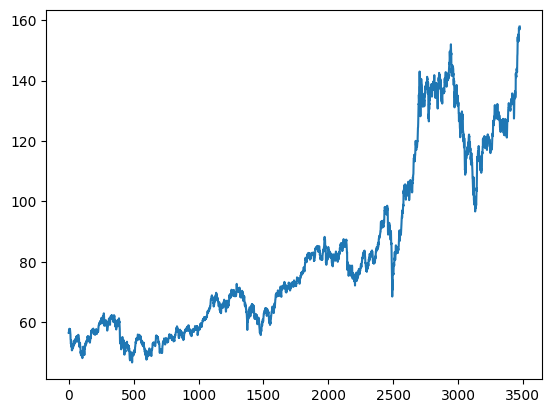

In [16]:
df2 = df.reset_index()['收盤價']
plt.plot(df2)

In [17]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(3476, 1)

In [18]:
train_size = int(len(df2)*0.65)
test_size = len(df2) - train_size
train_data, test_data = df2[0:train_size,:], df2[train_size:len(df2),:1]
# train_data,test_data = df2[0:train_size,:],df2[train_size:len(df2),:1]

In [19]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [20]:
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [21]:
# 調整數據形狀
X_train = X_train.reshape(-1, time_step, 1)
X_test = X_test.reshape(-1, time_step, 1)

In [22]:
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(2158, 100, 1)
[[[0.08780137]
  [0.08780137]
  [0.09724721]
  ...
  [0.02815761]
  [0.0302267 ]
  [0.02779777]]

 [[0.08780137]
  [0.09724721]
  [0.0958978 ]
  ...
  [0.0302267 ]
  [0.02779777]
  [0.02078086]]

 [[0.09724721]
  [0.0958978 ]
  [0.09904642]
  ...
  [0.02779777]
  [0.02078086]
  [0.0311263 ]]

 ...

 [[0.27581864]
  [0.25872616]
  [0.25782656]
  ...
  [0.29336092]
  [0.28256567]
  [0.28706369]]

 [[0.25872616]
  [0.25782656]
  [0.26097517]
  ...
  [0.28256567]
  [0.28706369]
  [0.28571429]]

 [[0.25782656]
  [0.26097517]
  [0.26277438]
  ...
  [0.28706369]
  [0.28571429]
  [0.28571429]]]
(1116, 100, 1)
(1116,)


In [23]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
34/34 [==============================] - 15s 221ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 2/100
34/34 [==============================] - 7s 222ms/step - loss: 2.9502e-04 - val_loss: 0.0034
Epoch 3/100
34/34 [==============================] - 6s 191ms/step - loss: 2.4582e-04 - val_loss: 0.0028
Epoch 4/100
34/34 [==============================] - 8s 223ms/step - loss: 2.2531e-04 - val_loss: 0.0025
Epoch 5/100
34/34 [==============================] - 6s 176ms/step - loss: 2.1497e-04 - val_loss: 0.0050
Epoch 6/100
34/34 [==============================] - 11s 329ms/step - loss: 2.2234e-04 - val_loss: 0.0021
Epoch 7/100
34/34 [==============================] - 15s 438ms/step - loss: 2.0939e-04 - val_loss: 0.0033
Epoch 8/100
34/34 [==============================] - 10s 287ms/step - loss: 2.1766e-04 - val_loss: 0.0034
Epoch 9/100
34/34 [==============================] - 7s 192ms/step - loss: 2.0402e-04 - val_loss: 0.0037
Epoch 10/100
34/34 [==============================] - 7

In [26]:
# 保存模型
model.save("Sotck_LSTM.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model("Sotck_LSTM.h5")

In [28]:

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

35/35 [==============================] - 1s 35ms/step


In [29]:
# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [30]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

65.45201240270916
117.51006267041898


In [31]:
look_back = 100

In [32]:
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [33]:
testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

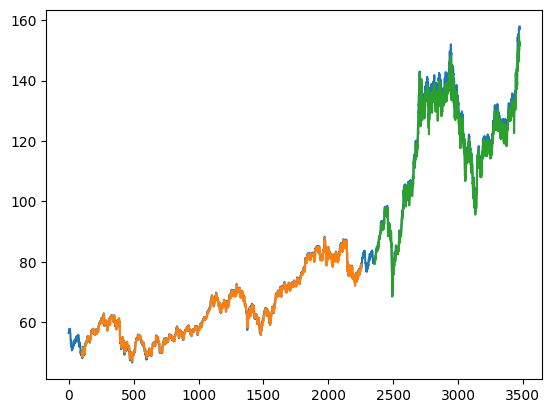

In [34]:
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()